In [2]:
!pip install pyyaml==5.1
# Версия torch 1.9.0
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# 
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
##### ПЕРЕЗАПУСТИТЕ СРЕДУ ####

  Using cached PyYAML-5.1-cp39-cp39-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 0.2.5 requires PyYAML>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [3]:
# Проверка версий
import torch
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

1.9.0+cu102 False


In [4]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random


from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo

from matplotlib import pyplot as plt

In [5]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YSXE7WwzEvf1S2uNYS6O")
project = rf.workspace("dselbrus").project("mask_no_mask-fw9uj")
dataset = project.version(10).download("coco")

  Using cached PyYAML-6.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (661 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mask_no_mask-10 in coco:: 100%|██████████| 1843/1843 [00:02<00:00, 802.71it/s] 


In [6]:
from detectron2.data import MetadataCatalog, DatasetCatalog

In [7]:
from detectron2.data import MetadataCatalog, DatasetCatalog
## регистрация датасетов
from detectron2.data.datasets import register_coco_instances
register_coco_instances("mask_train", {}, 
                        "/home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/train/_annotations.coco.json", 
                        "/home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/train")
register_coco_instances("mask_test", {}, 
                         "/home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/test/_annotations.coco.json", 
                         "/home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/test")

## Сохранение данных для работы сети
mask_metadata = MetadataCatalog.get("mask_train")
mask_dicts = DatasetCatalog.get("mask_train")

mask_metadata = MetadataCatalog.get("mask_test")
mask_dicts = DatasetCatalog.get("mask_test")

WARNING [07/29 12:57:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/29 12:57:18 d2.data.datasets.coco]: Loaded 1661 images in COCO format from /home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/train/_annotations.coco.json
WARNING [07/29 12:57:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/29 12:57:18 d2.data.datasets.coco]: Loaded 176 images in COCO format from /home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/Mask_no_mask-10/test/_annotations.coco.json


In [32]:
mask_metadata.thing_classes

['mask-detection', 'mask_weared_incorrect', 'with_mask', 'without_mask']

In [8]:
# DatasetCatalog.pop("mask_train")

In [9]:
# DatasetCatalog.pop("mask_test")

In [10]:
cfg = get_cfg()

In [11]:
cfg.MODEL.DEVICE = "cpu"

In [12]:
# Подгружаем обученную модель

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/home/anna/ds_bootcamp/ds_offline/model_mask_no_mask/model_final.pth")  # путь к обученной модели
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# устанавливаем порог обнаружения
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  

# создаем объект для построения предсказаний
predictor = DefaultPredictor(cfg)

    # "categories": [
    #     {
    #         "id": 1,
    #         "name": "mask_weared_incorrect",
    #         "supercategory": "mask-detection"
    #     },
    #     {
    #         "id": 2,
    #         "name": "with_mask",
    #         "supercategory": "mask-detection"
    #     },
    #     {
    #         "id": 3,
    #         "name": "without_mask",
    #         "supercategory": "mask-detection"

In [13]:
im = cv2.imread("musk_no_mask.png")
outputs = predictor(im)

floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)


In [14]:
im.shape

(755, 674, 3)

In [15]:
outputs

{'instances': Instances(num_instances=1, image_height=755, image_width=674, fields=[pred_boxes: Boxes(tensor([[191.7391, 113.3334, 469.2181, 474.0788]])), scores: tensor([0.9886]), pred_classes: tensor([3])])}

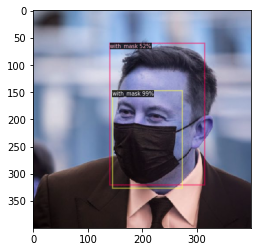

In [33]:
v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1]);

In [17]:
im = cv2.imread("musk_mask.jpg")
outputs = predictor(im)

In [18]:
outputs["instances"].pred_boxes

Boxes(tensor([[181.9959, 185.1471, 343.1152, 408.8662],
        [176.6455,  75.9085, 393.3691, 401.5775]]))

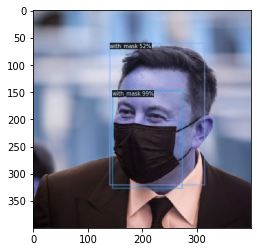

In [19]:
v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.8
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1]);